# 🌐 Introduction to PageRank: How Google Ranks the Web

PageRank is a famous algorithm developed by Google founders to rank web pages in search results. It uses the structure of the web—how pages link to each other—to determine which pages are most important. The magic behind PageRank? **Eigenvalues and eigenvectors!**

In this notebook, we'll build intuition for PageRank step by step, using simple examples, visualizations, and analogies. By the end, you'll understand how eigenproblems help Google (and you!) find the most relevant information on the web.

---

## 1. The Web as a Network

Imagine a tiny internet with just 4 pages: A, B, C, and D. Each page links to some of the others. We can represent this as a network (or graph):

- **Nodes**: Webpages (A, B, C, D)
- **Edges**: Links from one page to another

Let's visualize this mini-web:

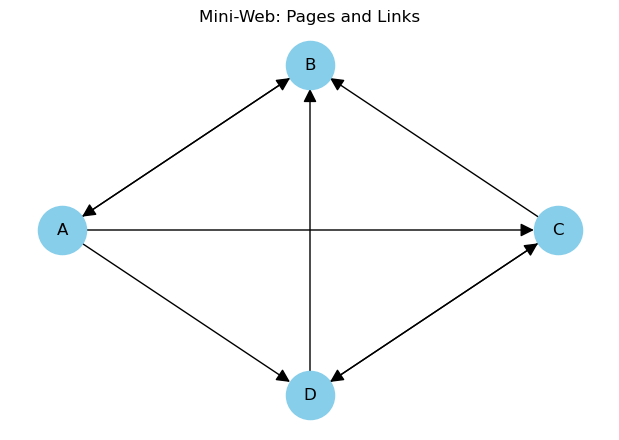

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# Define the directed graph
edges = [
    ('A', 'B'), ('A', 'C'), ('A', 'D'),
    ('B', 'A'),
    ('C', 'B'), ('C', 'D'),
    ('D', 'B'), ('D', 'C')
]
G = nx.DiGraph()
G.add_edges_from(edges)

plt.figure(figsize=(6, 4))
pos = {'A': (0, 1), 'B': (1, 2), 'C': (2, 1), 'D': (1, 0)}
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=1200, arrowstyle='-|>', arrowsize=20)
plt.title('Mini-Web: Pages and Links')
plt.show()

## 2. From Links to Probabilities: The Link Matrix

Suppose you are a web surfer who randomly clicks links. The chance of moving from one page to another depends on the links available. We can capture this with a **link matrix** $L$:

- Each column of $L$ represents a page *you are on*
- Each row of $L$ represents a page *you might go to next*
- The entry $L_{ij}$ is the probability of moving from page $j$ to page $i$

Let's build the link matrix for our mini-web. We'll use the following rules:
- If a page has $k$ outgoing links, each link has probability $1/k$
- If there is no link, the probability is 0

Let's write out the link vectors for each page:

In [6]:
# Build the link matrix L
# Order: [A, B, C, D]
L = np.array([
    # A     B     C     D
    [0,    1,    0,    0],      # To A
    [1/3,  0,    1/2,  1/2],    # To B
    [1/3,  0,    0,    1/2],    # To C
    [1/3,  0,    1/2,  0]       # To D
])

import pandas as pd
L_df = pd.DataFrame(L, columns=['A', 'B', 'C', 'D'], index=['A', 'B', 'C', 'D'])
print("Link Matrix L (rows: destination, columns: current page):")
display(L_df)

Link Matrix L (rows: destination, columns: current page):


,A,B,C,D
A,0.000000,1.0,0.0,0.0
B,0.333333,0.0,0.5,0.5
C,0.333333,0.0,0.0,0.5
D,0.333333,0.0,0.5,0.0


## 3. Ranking Pages: The Power of Iteration

Suppose a random surfer (let's call them "Procrastinating Pat") clicks links forever. How much time will Pat spend on each page in the long run? This is the **PageRank** of each page!

We represent the current "importance" (or rank) of each page as a vector $r$:

$$
r = \begin{bmatrix} r_A \\ r_B \\ r_C \\ r_D \end{bmatrix}
$$

The rule is simple:
- At each step, update $r$ by multiplying with the link matrix $L$
- Repeat until $r$ stops changing (converges)

This process is called the **power method**. Let's see it in action!

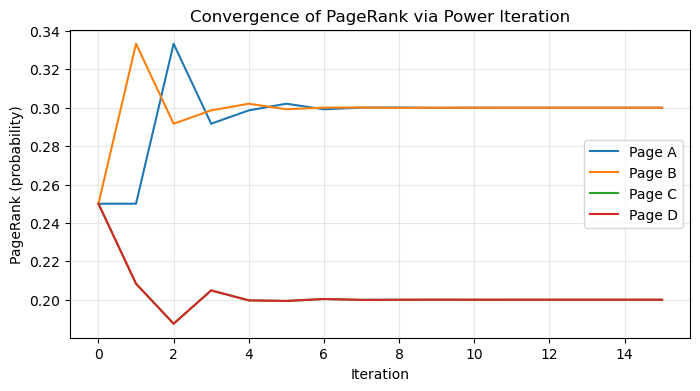

Final PageRank vector:
Page A: 0.300
Page B: 0.300
Page C: 0.200
Page D: 0.200


In [7]:
# Power iteration to compute PageRank
num_pages = 4
r = np.ones(num_pages) / num_pages  # Start with equal rank
history = [r.copy()]

for i in range(15):
    r = L @ r
    r = r / r.sum()  # Normalize (optional for intuition)
    history.append(r.copy())

history = np.array(history)

# Plot convergence
plt.figure(figsize=(8, 4))
for i, label in enumerate(['A', 'B', 'C', 'D']):
    plt.plot(history[:, i], label=f'Page {label}')
plt.xlabel('Iteration')
plt.ylabel('PageRank (probability)')
plt.title('Convergence of PageRank via Power Iteration')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("Final PageRank vector:")
for i, label in enumerate(['A', 'B', 'C', 'D']):
    print(f"Page {label}: {r[i]:.3f}")

## 4. Why Does This Work? The Eigenvector Connection

Notice how the rank vector $r$ eventually stops changing, even as we keep multiplying by $L$:

$$
L r = r
$$

This means $r$ is an **eigenvector** of $L$ with eigenvalue 1! In other words, $r$ points in a direction that is unchanged by $L$—it is the "steady state" of the web surfer.

**Analogy:**
- Imagine stirring a cup of coffee. No matter how you swirl, the liquid eventually settles into a calm state. The PageRank vector is like that calm state: the long-term behavior of the system.

**Key idea:**
- The most important pages are those that end up with the highest values in $r$
- The process always finds the dominant eigenvector (the one with eigenvalue 1) because of how the web is structured

Let's check this mathematically:

In [8]:
# Compute eigenvalues and eigenvectors of L
vals, vecs = np.linalg.eig(L)

# Find the eigenvector corresponding to eigenvalue 1
idx = np.argmin(np.abs(vals - 1))
pagerank_eigenvector = np.real(vecs[:, idx])
pagerank_eigenvector = pagerank_eigenvector / pagerank_eigenvector.sum()  # Normalize

print("Eigenvalues of L:", np.round(vals, 3))
print("\nPageRank eigenvector (normalized):")
for i, label in enumerate(['A', 'B', 'C', 'D']):
    print(f"Page {label}: {pagerank_eigenvector[i]:.3f}")

print("\nCompare to the result from power iteration above!")

Eigenvalues of L: [ 1.  +0.j    -0.25+0.323j -0.25-0.323j -0.5 +0.j   ]

PageRank eigenvector (normalized):
Page A: 0.300
Page B: 0.300
Page C: 0.200
Page D: 0.200

Compare to the result from power iteration above!


## 5. The Damping Factor: Random Jumps

In the real web, sometimes a user doesn't follow a link—they just type a new address or jump to a random page. To model this, PageRank uses a **damping factor** $d$ (usually around 0.85):

$$
r_{\text{new}} = d \cdot L r_{\text{old}} + (1-d) \cdot \frac{1}{n} \mathbf{1}
$$

- $d$ = probability of following a link (e.g., 0.85)
- $1-d$ = probability of jumping to a random page
- $n$ = number of pages

**Analogy:**
- Imagine Pat gets bored and sometimes just types a random URL instead of clicking a link. This keeps the system fair and ensures every page can be reached.

Let's see how the damping factor changes the PageRank calculation:

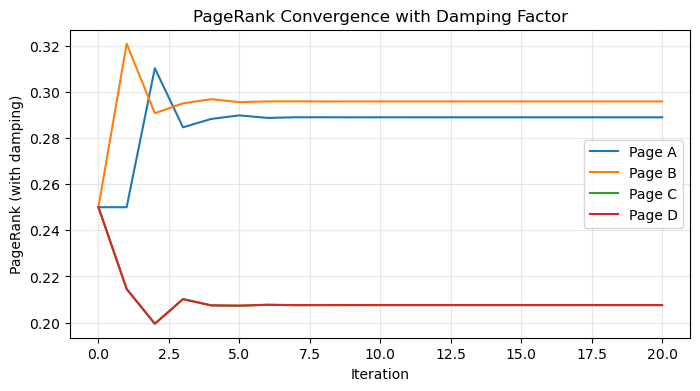

Final PageRank vector with damping:
Page A: 0.289
Page B: 0.296
Page C: 0.208
Page D: 0.208


In [9]:
# Power iteration with damping factor
d = 0.85
num_pages = 4
r = np.ones(num_pages) / num_pages
history_damped = [r.copy()]

for i in range(20):
    r = d * (L @ r) + (1 - d) / num_pages
    r = r / r.sum()
    history_damped.append(r.copy())

history_damped = np.array(history_damped)

plt.figure(figsize=(8, 4))
for i, label in enumerate(['A', 'B', 'C', 'D']):
    plt.plot(history_damped[:, i], label=f'Page {label}')
plt.xlabel('Iteration')
plt.ylabel('PageRank (with damping)')
plt.title('PageRank Convergence with Damping Factor')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("Final PageRank vector with damping:")
for i, label in enumerate(['A', 'B', 'C', 'D']):
    print(f"Page {label}: {r[i]:.3f}")

## 6. Summary: PageRank, Eigenvectors, and the Web

- **PageRank** uses the structure of the web to rank pages by importance
- The process is based on **random walks** and **probabilities**
- The steady-state solution is the **dominant eigenvector** of the link matrix
- The **damping factor** models real user behavior and ensures fairness

**Visual Analogy:**
- Imagine a marble rolling around a network of tubes (the web). The places where the marble spends the most time are the most important pages!

**Why is this powerful?**
- PageRank revolutionized web search by using math to find the most relevant information
- The same ideas are used in many fields: social networks, biology, recommendation systems, and more

---

### 🚀 Next Steps
- Try changing the network structure and see how PageRank changes
- Explore larger networks and see how the power method scales
- Learn about other applications of eigenvectors in data science and engineering

**Congratulations!** You now understand the core ideas behind PageRank and how eigenvectors help us make sense of the web.